In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot, network_sender_receiver
from filters import butter_lowpass
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy
import torchaudio
from scipy.stats import norm

C:\Users\Toldbodgade1\anaconda3\envs\thesis_env\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
def get_data():

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)
    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y

In [5]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss
# Remember to double check padding and general design of NN_tx and NN_rx

Xtrain, ytrain = get_data()
Xtest, ytest = get_data()

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

0.8944271909999159
Using CPU
0  loss: 1.5150431394577026
0  acc: 0.24732999503612518


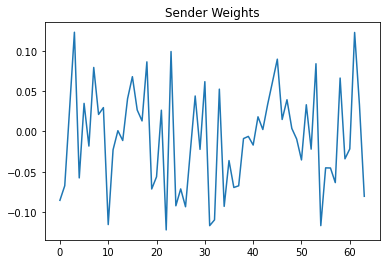

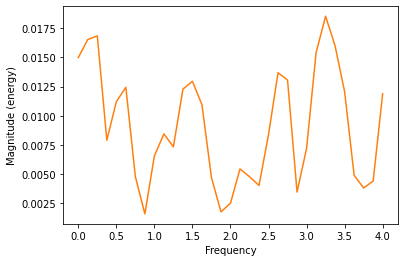

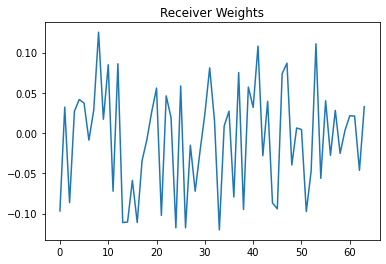

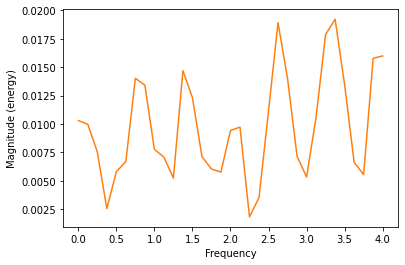

100  loss: 0.9113447070121765
100  acc: 0.5954300165176392


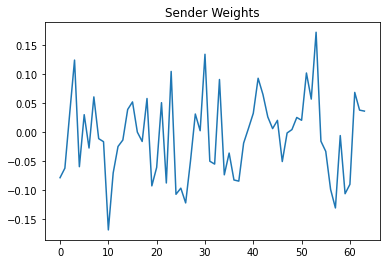

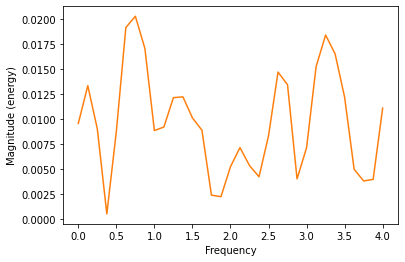

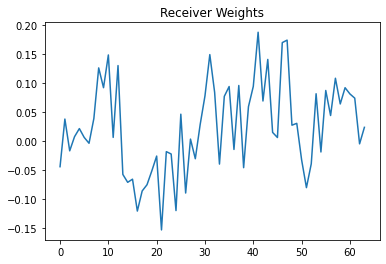

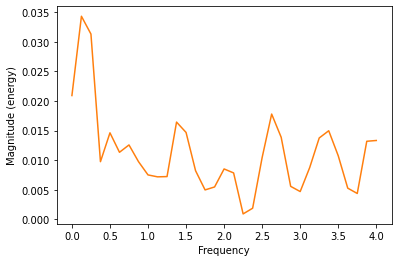

200  loss: 0.7061124444007874
200  acc: 0.6605499982833862


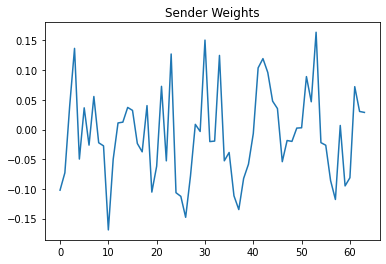

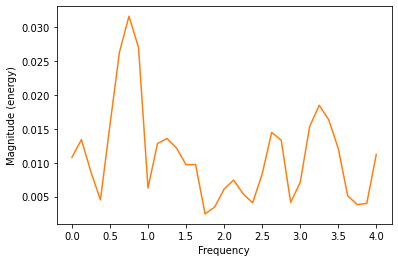

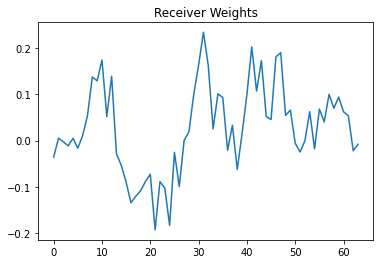

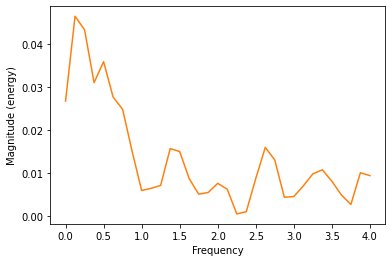

300  loss: 0.6173573732376099
300  acc: 0.7116600275039673


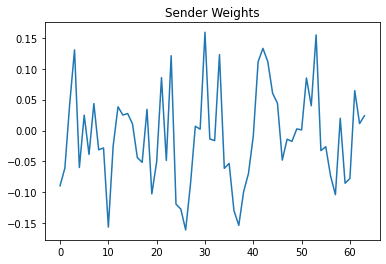

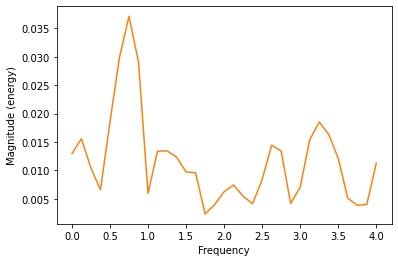

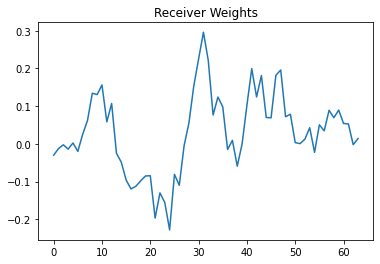

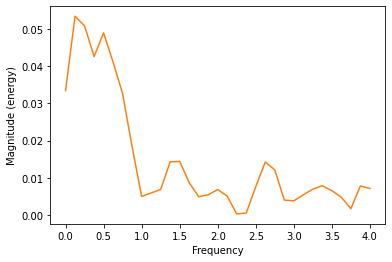

400  loss: 0.5600967407226562
400  acc: 0.757830023765564


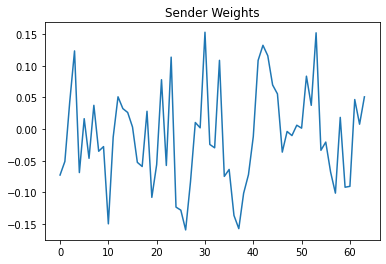

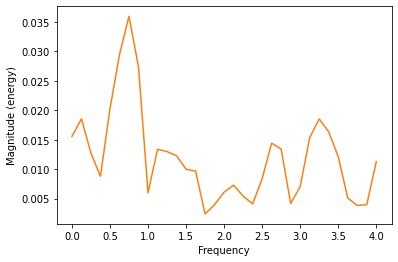

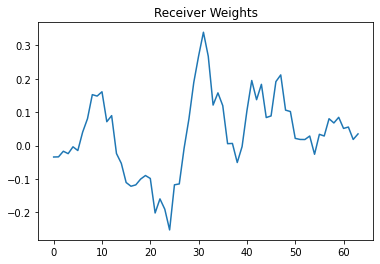

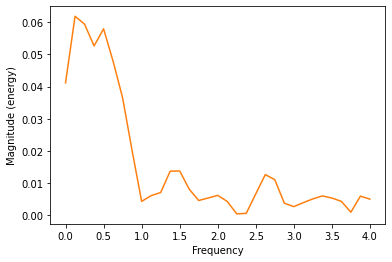

500  loss: 0.5179374814033508
500  acc: 0.7943599820137024


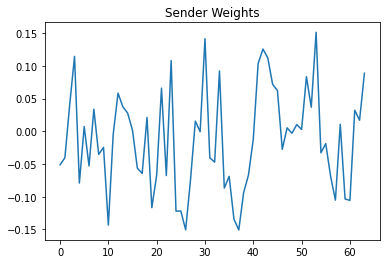

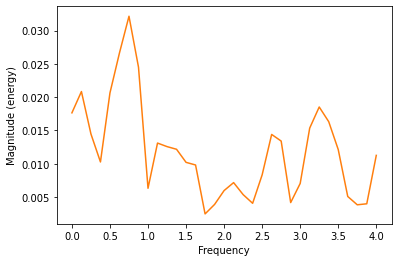

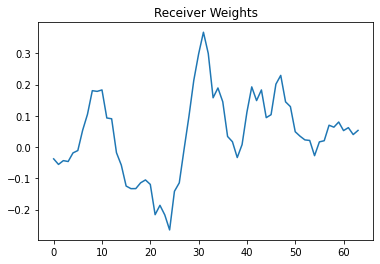

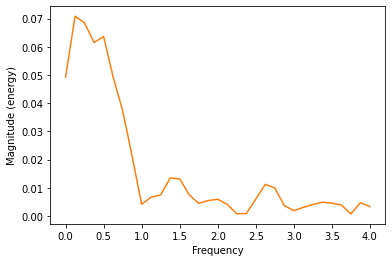

600  loss: 0.4937698543071747
600  acc: 0.8160600066184998


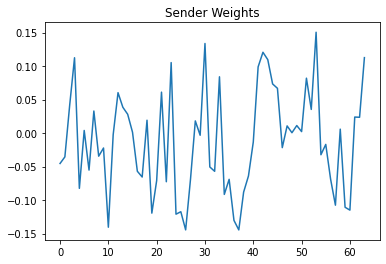

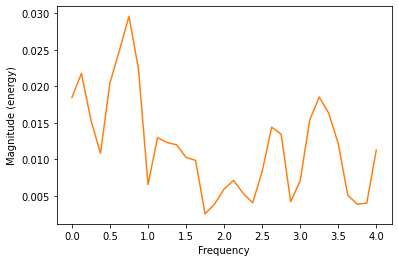

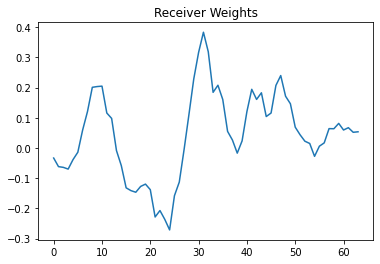

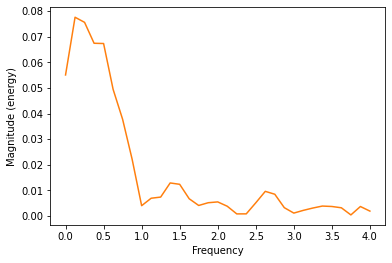

700  loss: 0.4743089973926544
700  acc: 0.8293899893760681


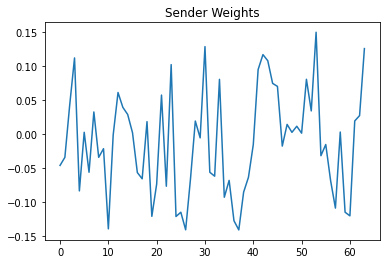

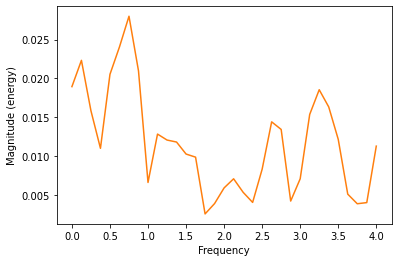

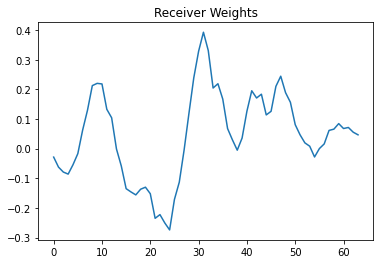

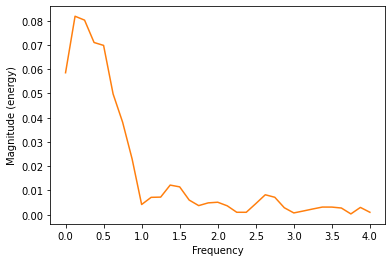

800  loss: 0.4565299153327942
800  acc: 0.8414599895477295


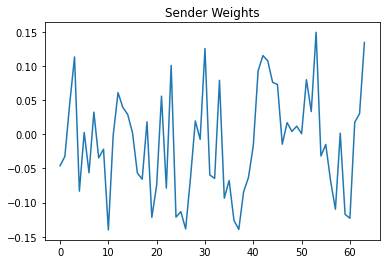

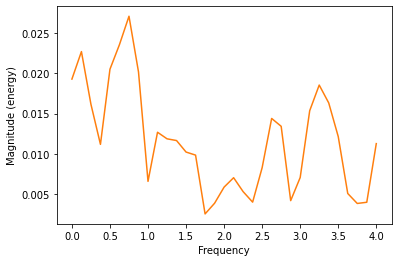

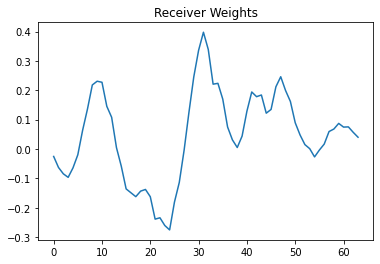

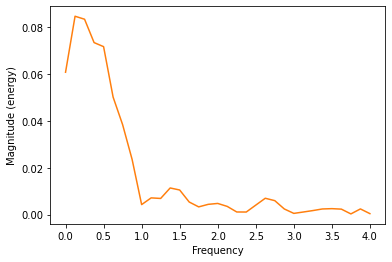

900  loss: 0.4419514536857605
900  acc: 0.8496800065040588


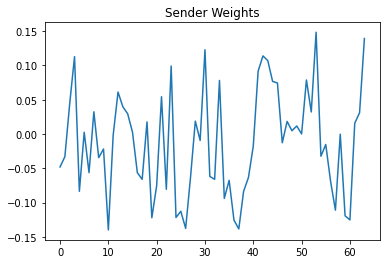

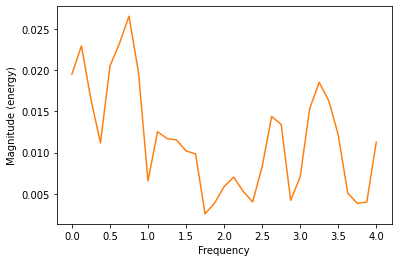

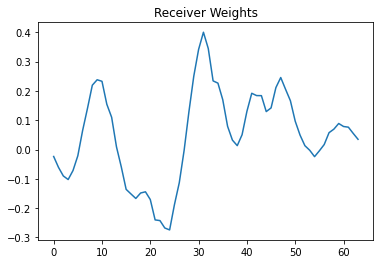

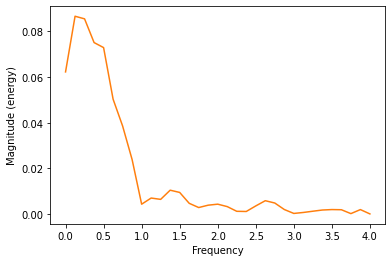

1000  loss: 0.4340270757675171
1000  acc: 0.8520799875259399


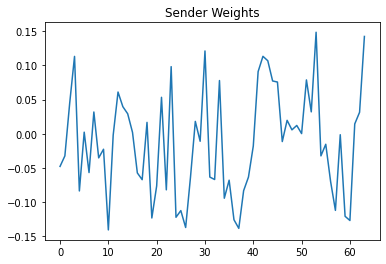

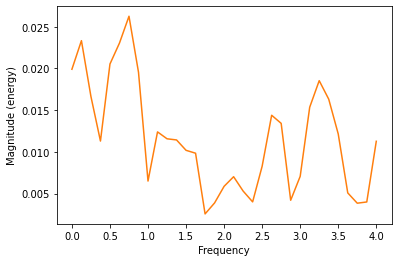

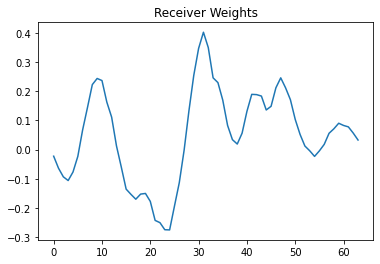

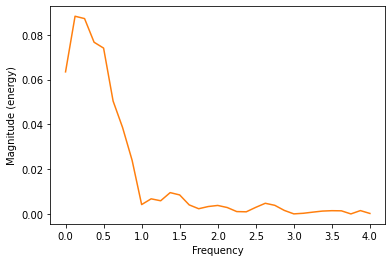

1100  loss: 0.41953244805336
1100  acc: 0.8584700226783752


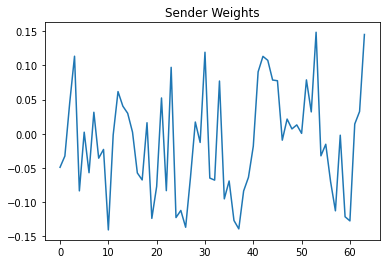

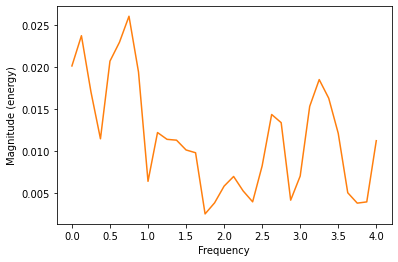

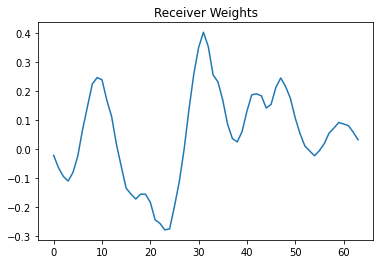

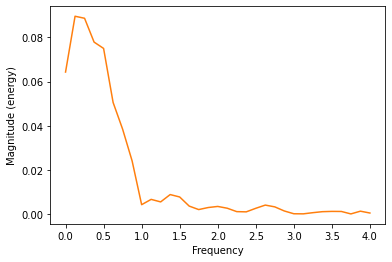

1200  loss: 0.4069807827472687
1200  acc: 0.8637199997901917


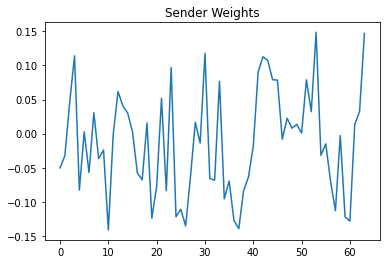

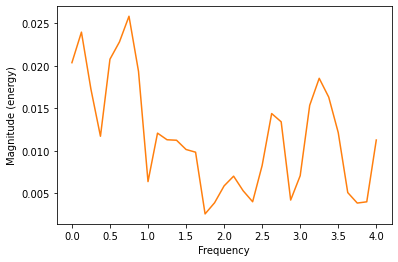

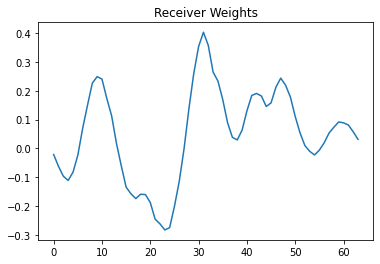

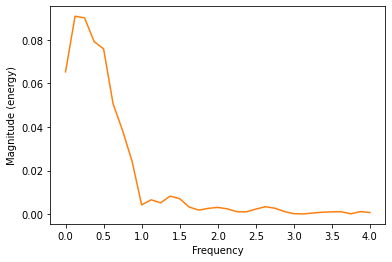

1300  loss: 0.4002212882041931
1300  acc: 0.8648999929428101


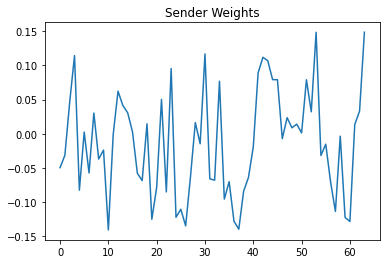

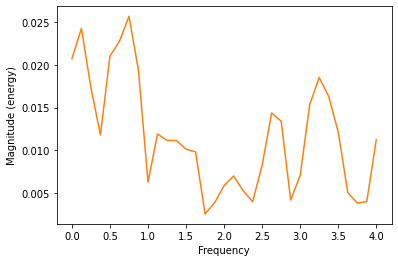

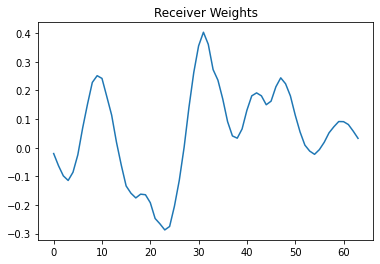

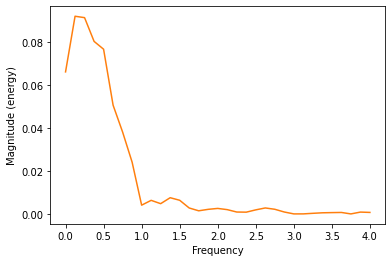

1400  loss: 0.3910158574581146
1400  acc: 0.8695600032806396


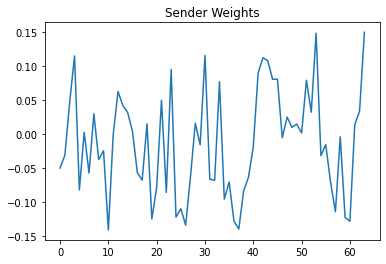

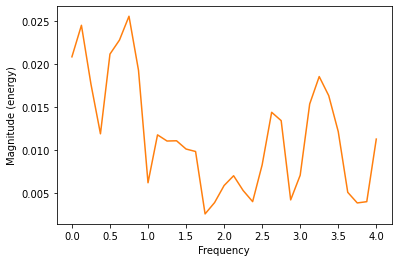

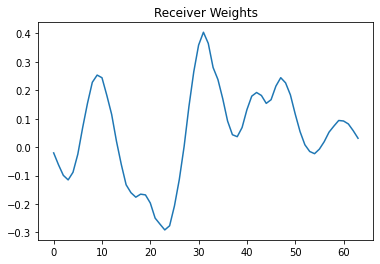

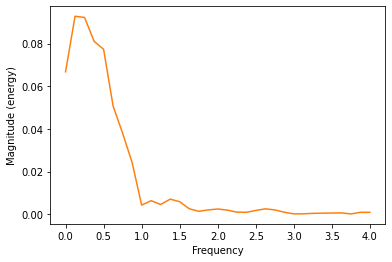

1500  loss: 0.3853720724582672
1500  acc: 0.8684300184249878


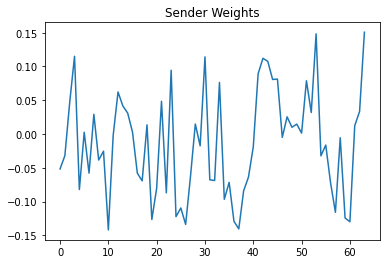

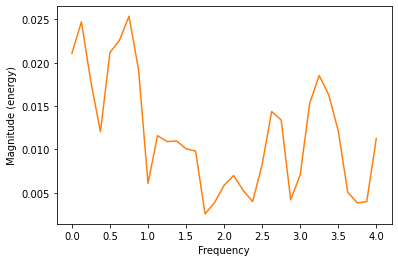

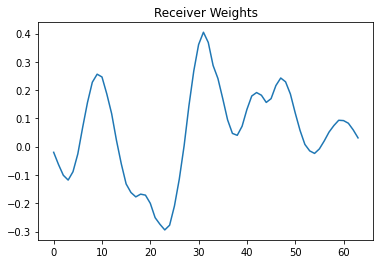

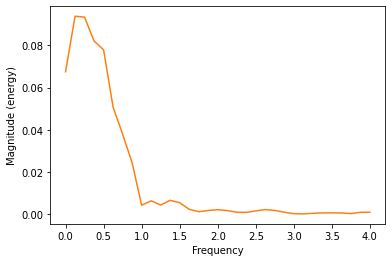

1600  loss: 0.37469789385795593
1600  acc: 0.8715199828147888


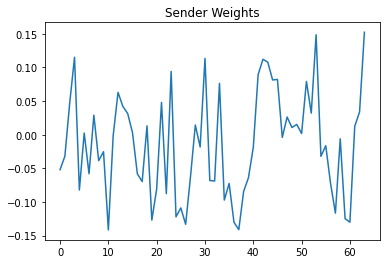

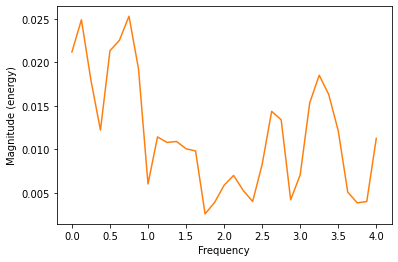

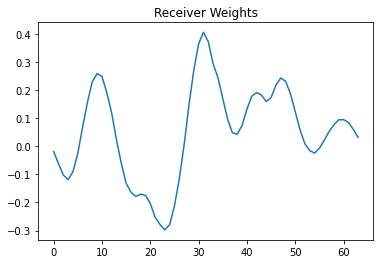

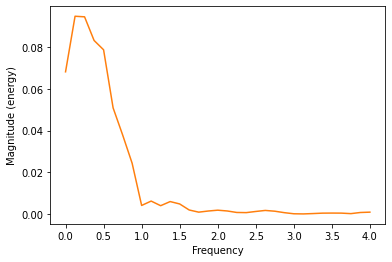

1700  loss: 0.37020957469940186
1700  acc: 0.8743299841880798


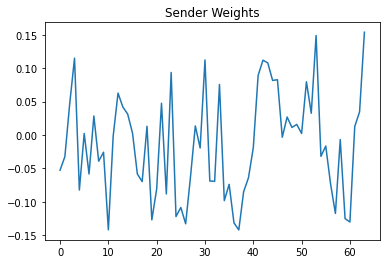

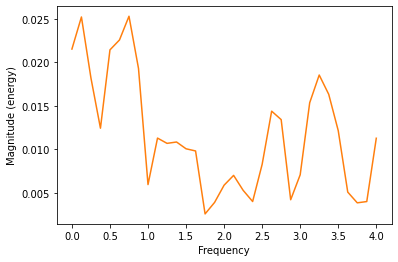

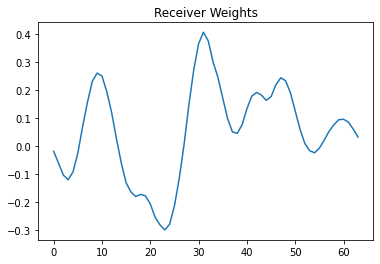

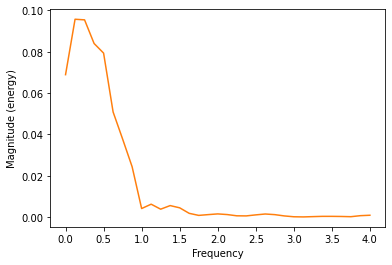

1800  loss: 0.3636684715747833
1800  acc: 0.873989999294281


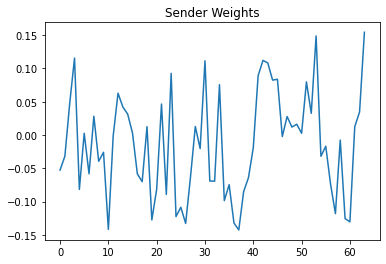

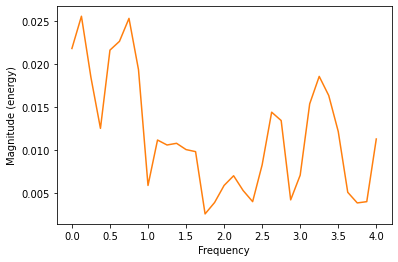

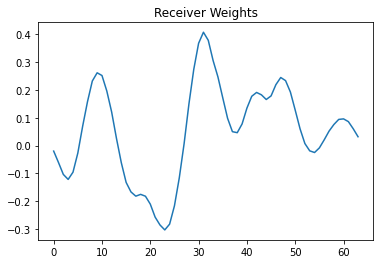

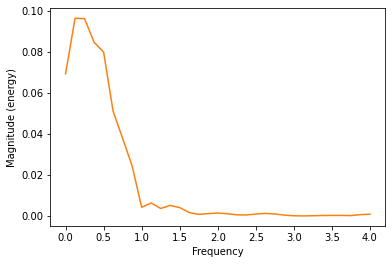

1900  loss: 0.35959914326667786
1900  acc: 0.8747100234031677


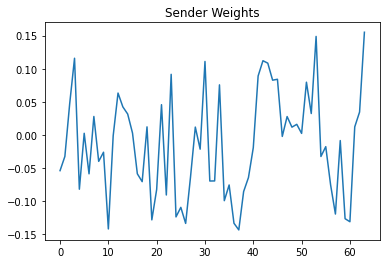

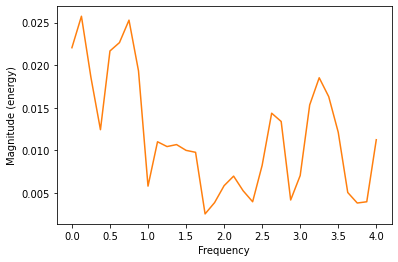

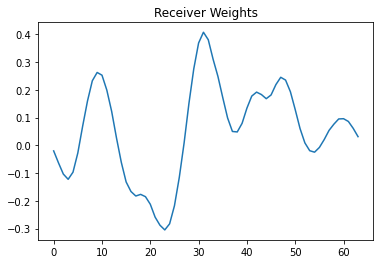

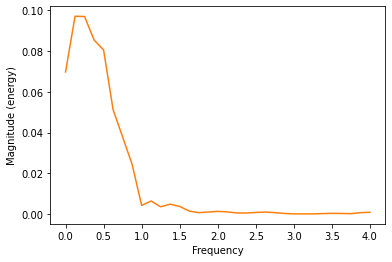

2000  loss: 0.3546213209629059
2000  acc: 0.8763899803161621


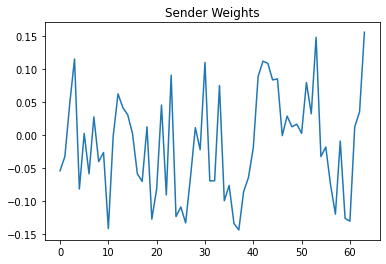

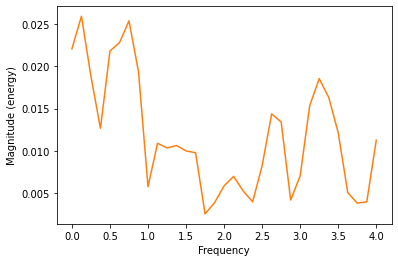

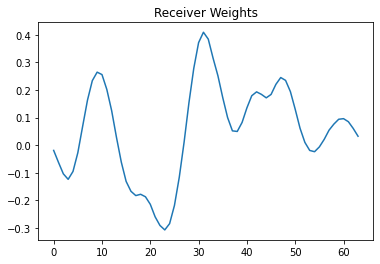

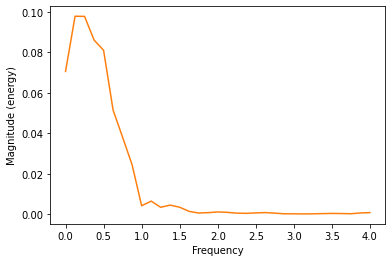

2100  loss: 0.3481384813785553
2100  acc: 0.878250002861023


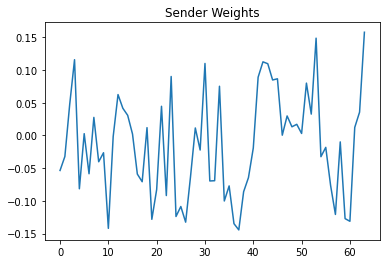

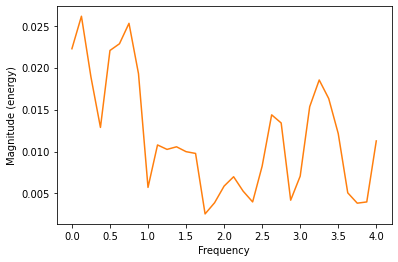

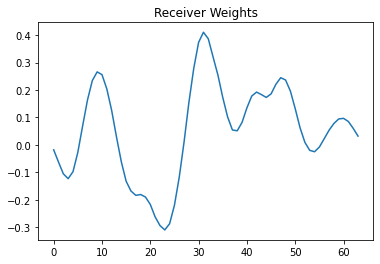

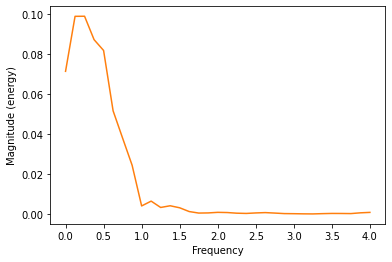

2200  loss: 0.34731677174568176
2200  acc: 0.8765599727630615


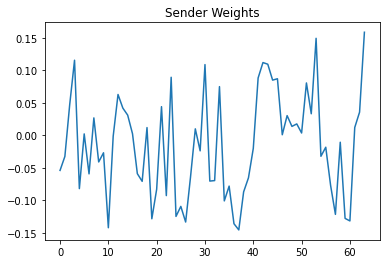

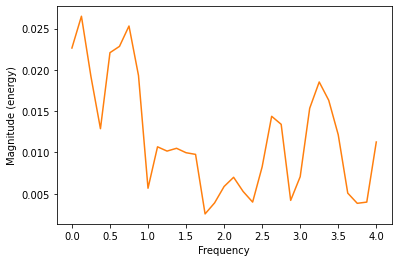

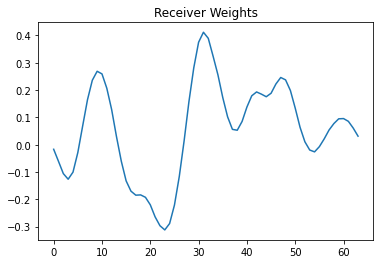

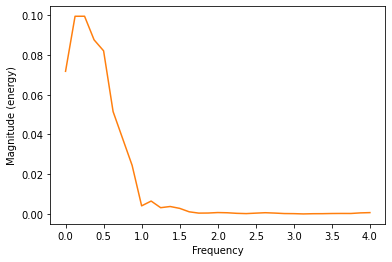

2300  loss: 0.34268757700920105
2300  acc: 0.8774499893188477


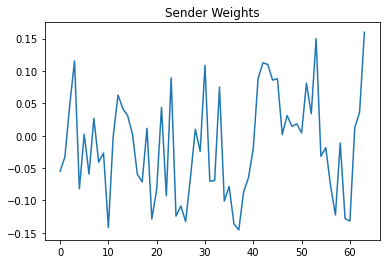

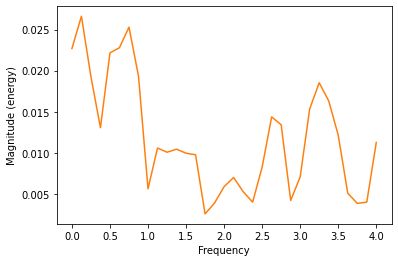

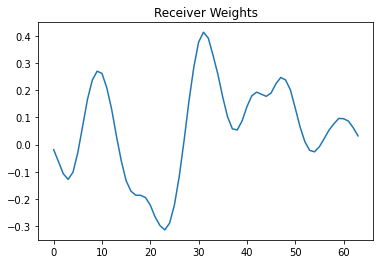

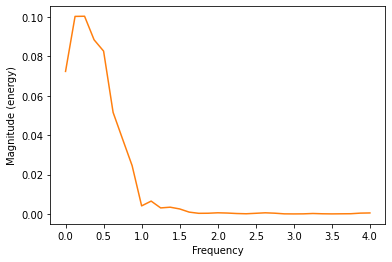

2400  loss: 0.3385254442691803
2400  acc: 0.8778200149536133


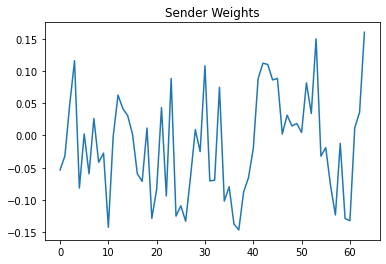

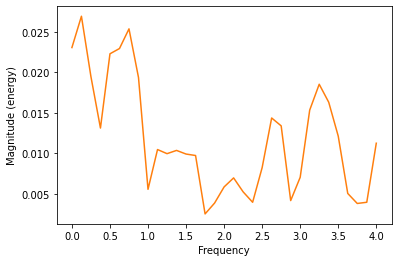

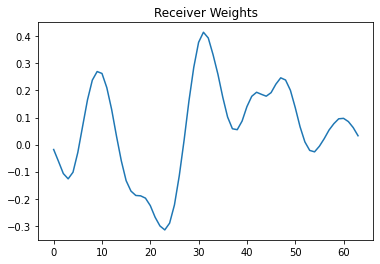

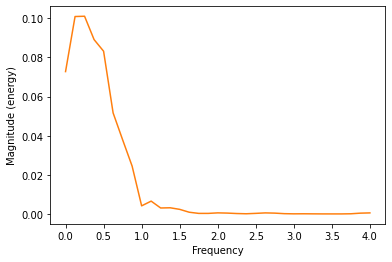

2500  loss: 0.3376081883907318
2500  acc: 0.8756700158119202


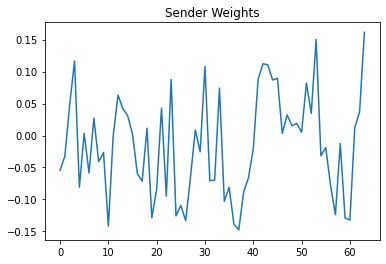

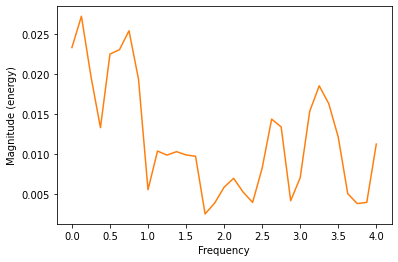

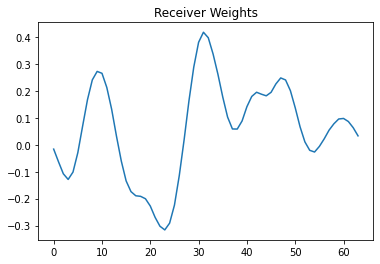

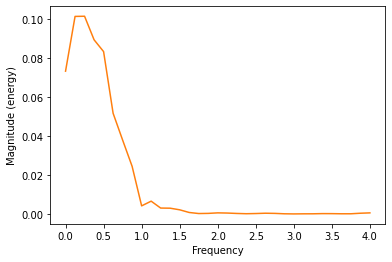

2600  loss: 0.33231526613235474
2600  acc: 0.8780500292778015


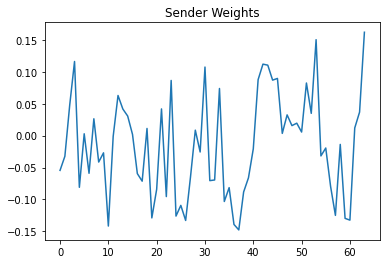

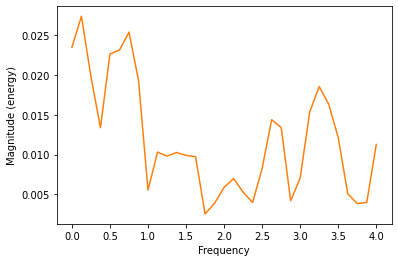

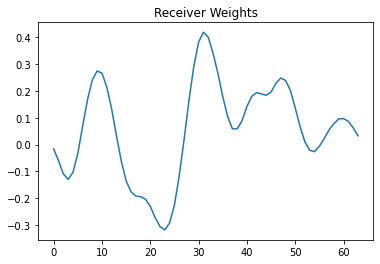

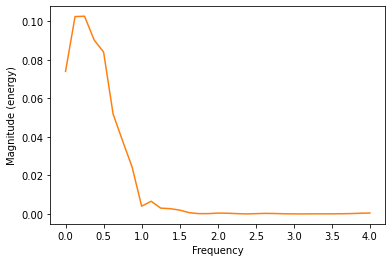

2700  loss: 0.32946890592575073
2700  acc: 0.8786500096321106


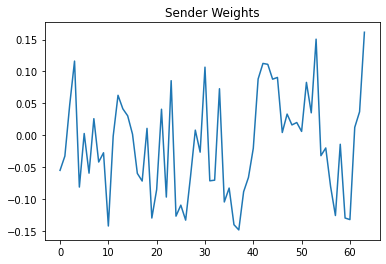

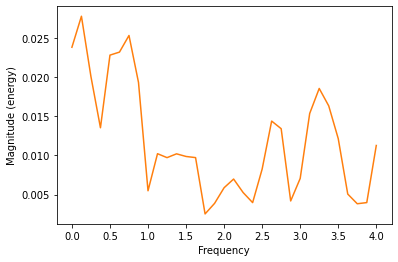

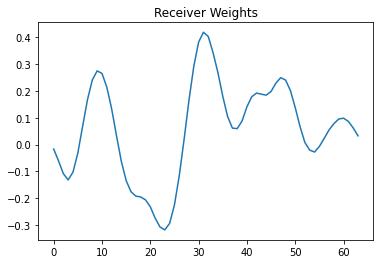

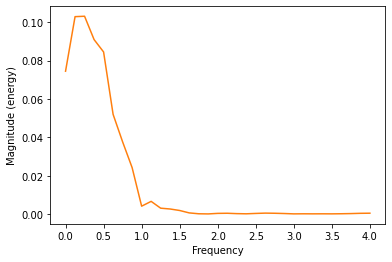

2800  loss: 0.32679280638694763
2800  acc: 0.8794299960136414


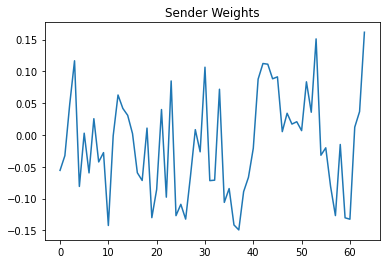

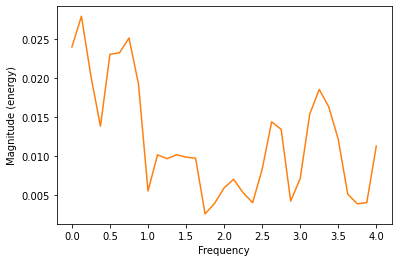

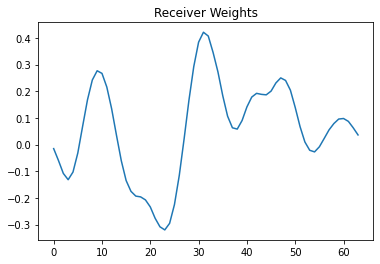

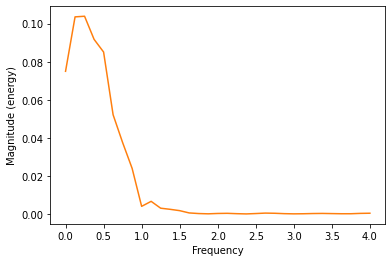

2900  loss: 0.3221912086009979
2900  acc: 0.8807899951934814


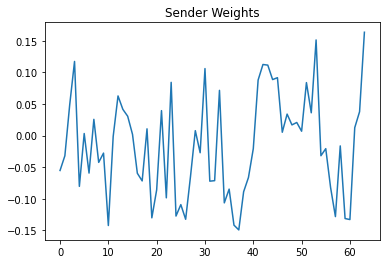

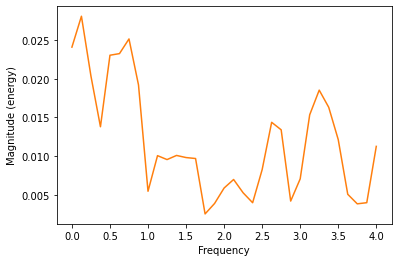

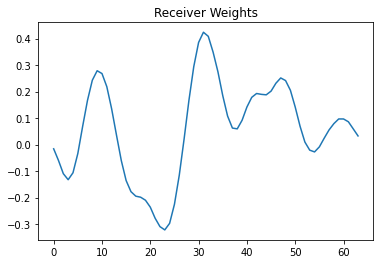

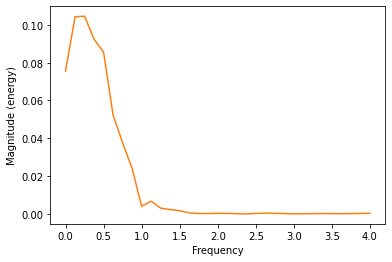

In [ ]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, sample_rate=CS.m, 
                                epochs=3000, cutoff_freq=0.5, v=True, use_cuda=False, SNRdb=10, plot_iteration=100)

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses.to('cpu'))
plt.show()

In [ ]:
# Evaluate

SNR = 10
joint_decisions = CS.transmission(SNRdb=SNR, mode='joint', joint_cutoff=0.3, model=[NN_tx, NN_rx])
print('Accuracy:', 1 - CS.evaluate(joint_decisions)[1])

In [ ]:
SNRdbs, euclid_er, network_er, NN_er, block_er, joint_er,  error_theory = \
SNR_plot(num_symbols=10000, joint_cutoff=0.3, joint_models=[NN_tx, NN_rx]) #[NN_tx, NN_rx]
                                                                                          

plt.figure(figsize=(18,11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRdbs[num:], euclid_er[num:])
#plt.semilogy(SNRdbs[num:], NN_er[num:])
#plt.semilogy(SNRdbs[num:], block_er[num:])
plt.semilogy(SNRdbs[num:], network_er[num:])
plt.semilogy(SNRdbs[num:], joint_er[num:], alpha=1)
plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=1)
legend0 = ['Receiver Network', 'Theory']
legend1 = ['Euclidean', 'Receiver Network', 'Joint Networks', 'Theory']
legend2 = ['Euclidean', 'NN Dec Maker', 'Block', 'Receiver Network', 'Joint Networks', 'Theory']
plt.legend(legend1, fontsize=16)
plt.show()